# T000 · NeuralPLexer an easy-to-follow usage guide

Authors:

- Katharina Buchthal 2024 Volkamerlab, Saarland University, Germany
- Maximilian Bähr 2024 Volkamerlab, Saarland University, Germany


*The examples used in this talktorial template are taken from [__Talktorial T001__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T001_query_chembl/talktorial.ipynb) and [__Talktorial T002__](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T002_compound_adme/talktorial.ipynb).*

<div class="alert alert-block alert-info">

<b>Cross-referencing talktorials</b>: If you want to cross-reference to existing talktorials in your notebook, please use the following formatting: <b>Talktorial T000</b>.

</div>

## Aim of this talktorial

Understanding the basics of Neuralplexer and beeing able to use it.

### Contents in *Theory*

_Add Table of Contents (TOC) for Theory section._

* Diffusion Models
* 

### Contents in *Practical*

_Add Table of Contents (TOC) for Practical section._

* Installing and executing Neuralplexer
* Dock sample Molecules to compare predictions with docking results
* Evaluating the performance of Neuralplexer

<div class="alert alert-block alert-info">

<b>Sync TOC with section titles</b>: These points should refer to the headlines of your <i>Practical</i> section.

</div>

### References

* Paper 
* Tutorial links
* Other useful resources

*We suggest the following citation style:*
* Keyword describing resource: <i>Journal</i> (year), <b>volume</b>, pages (link to resource) 

*Example:*
* ChEMBL web services: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881) 

## Theory

### Diffusion Models

Diffusion models are cool

![ChEMBL web service schema](./images/example_plot.png)

*Figure 1:* 
Describe figure and add reference.
Figure and description taken from: [<i>Nucleic Acids Res.</i> (2015), <b>43</b>, 612-620](https://academic.oup.com/nar/article/43/W1/W612/2467881).

<div class="alert alert-block alert-info">
    
<b>Figures</b>: Place images in the <code>images/</code> folder and include them using Markdown <code>![Figure title](images/some_figure.jpg)</code>. Add a figure caption in the format shown in the example.

</div>

### Compound activity measures

Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet. Lorem ipsum dolor sit amet, consetetur sadipscing elitr, sed diam nonumy eirmod tempor invidunt ut labore et dolore magna aliquyam erat, sed diam voluptua. At vero eos et accusam et justo duo dolores et ea rebum. Stet clita kasd gubergren, no sea takimata sanctus est Lorem ipsum dolor sit amet.

$pIC_{50} = -log_{10}(IC_{50}*10^{-9})= 9-log_{10}(IC_{50}) $

<div class="alert alert-block alert-info">
    
<b>Formulas</b>: Please use LaTeX to format formulas.
</div>

If you place links, please link descriptive words.

> __Yes__: [ChEMBL](https://www.ebi.ac.uk/chembl/) is a manually curated database of bioactive molecules

> __No__: ChEMBL ([here](https://www.ebi.ac.uk/chembl/)) is a manually curated database of bioactive molecules

<div class="alert alert-block alert-info">
    
<b>Links</b>: If you place links, please link descriptive words.

</div>

## Practical

TODO

<div class="alert alert-block alert-info">

<b>Sync section titles with TOC</b>: Please make sure that all section titles in the <i>Practical</i> section are synced with the bullet point list provided in the <i>Aim of this talktorial</i> > <i>Contents in Practical</i> section.

</div>

In [1]:
# imports
import os
import subprocess
from pathlib import Path
import nglview as nv
from rdkit.Chem import rdMolAlign
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from rdkit.Chem.Draw import MolsToGridImage
import MDAnalysis as mda
import Bio.PDB
from MDAnalysis.analysis.dihedrals import Ramachandran
import matplotlib.pyplot as plt
import mdtraj

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

### Installation of NeuralPLexer
In this section, we will install NeuralPLexer, including its rerquired envrionment. To this end, we will (1) clone the repository, (2) create the conda envrionment, and (3) install NeuralPLexer itself. Note that the installation was only tested for Linux, and might only work for machines with Cuda capable graphic cards. In case, NeuralPLexer cannot be installed, we provide all generated files that are required for this notebook within the `data` directory.

If you already have NeuralPLexer installed, or NeuralPLexer cannot be installed on your machine, this section can be skipped. 

If you are planning on using WSL (Windows Subsystem for Linux), you can check the following versions:

- **WSL-Version**: 2.3.26.0  
- **Kernelversion**: 5.15.167.4-1  
- **WSLg-Version**: 1.0.65  
- **MSRDC-Version**: 1.2.5620  
- **Direct3D-Version**: 1.611.1-81528511  
- **DXCore-Version**: 10.0.26100.1-240331-1435.ge-release  
- **Windows-Version**: 10.0.22621.4317  

Environment Setup:

- **conda**: 24.5.0  
- **Python**: 3.10.16  
- **pip**: 22.0.2  

**Note**: The installation can work on other versions, but in the scope of this installation, we will stick to these versions.

Before we will start with the installtion, we define a tiny helper function that allows us to run shell command, to check whether it succeed using the pyhton `subprocess` package. Later, we will need to run shell commands within the NeuralPLexer envrionment `neuralplexer_dev` - mainly when running neuralplexer itself. For that purpose, we use the `envrionment` parameter. If `envrionment` is set, we execute the command within the given conda envrionment using `conda run -n <envrionment> <command>`. Further, when we will later run NeuralPLexer, we need to specify TODO @Max, for that purpose we use the variable `use_pyhton_directive`

In [3]:
def run_shell_command(
    cmd,
    description="",
    environment=None,
    use_pyhton_directive=False,
    print_success=True,
    suppress_output=False,
):
    """
    Executes shell command using subprocess and checks wether is suceeds.
    If envrionment is given, this command is executed in this envrionment.

    Parameters
    ----------
    cmd: str
        Command that should be executed
    description: str
        Description of success (will be printed in case of success)
    envrionment: str
        Excisting (!) conda environment. If specifed, cmd will be executed in this envrionment
    use_pyhton_directive: boolean @Max naming
        If true, PYTHONPATH=$PYTHONPATH:$(pwd) is prepended to the command.
        This is needed to execute python scripts when using conda run -n (? @Max)
    print_success: boolean
        If true, also prints message when cmd was successfully executed
    suppress_output: booloean
        If true, std output is suppressed
    """

    full_command = (
        (
            "PYTHONPATH=$PYTHONPATH:$(pwd) " if use_pyhton_directive else ""
        )  # add python path
        + (
            f"conda run -n {environment} " if environment else ""
        )  # if given, set conda environment
        + cmd
    )

    print("Running", full_command)

    # run command
    res = subprocess.run(full_command, shell=True, capture_output=suppress_output)

    # check if cmd is executed succesfully
    if res.returncode != 0:
        # error occured
        print(f"Error when executing {full_command}")
    elif print_success:
        # print success
        print(f"Successfully {description}")

(1) Clone the repository into the current directory

In [5]:
run_shell_command(
    "git clone https://github.com/zrqiao/NeuralPLexer.git", "cloned repository"
)

Running git clone https://github.com/zrqiao/NeuralPLexer.git


Cloning into 'NeuralPLexer'...


Successfully cloned repository


(2) Create the NeuralPLexer environment from `NeuralPLexer/environment_dev.yaml`.

**Note:** This might take a while (~2-5 minutes).

In [61]:
run_shell_command(
    "conda env create -f NeuralPLexer/environment_dev.yaml", "created conda environment"
)

Running conda env create -f NeuralPLexer/environment_dev.yaml
Channels:
 - nvidia
 - pytorch
 - pytorch3d
 - pyg
 - bioconda
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: ...working... done

Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Installing pip dependencies: | Ran pip subprocess with arguments:
['/home/katharina/miniconda3/envs/neuralplexer_dev/bin/python', '-m', 'pip', 'install', '-U', '-r', '/home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/NeuralPLexer/condaenv.israfyv1.requirements.txt', '--exists-action=b']
Pip subprocess output:
  Using cached DLLogger-1.0.0-py3-none-any.whl
  Using cached openfold-1.0.1-cp310-cp310-linux_x86_64.whl
  Using cached power_spherical-0.1.0-py3-none-any.whl
  Cloning https://github.com/facebookresearch/esm (to revision 57da016e5d740a9ac5bcf62c3689a42e88584bc) to /tmp/pip-install-e_wl8r0a/fair-esm_a68d82c4a052493e8f2f1c4a688fde29
  Resolved https://github.com/facebookresearch/esm to 

Now, the NeuralPLexer environment should be created. We can check this but listing all packages wihtin this envrionment:

In [7]:
run_shell_command("conda list", environment="neuralplexer_dev", print_success=False)

Running conda run -n neuralplexer_dev conda list
# packages in environment at /home/katharina/miniconda3/envs/neuralplexer_dev:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
absl-py                   2.1.0              pyhd8ed1ab_1    conda-forge
aiohappyeyeballs          2.4.4                    pypi_0    pypi
aiohttp                   3.11.11                  pypi_0    pypi
aiosignal                 1.3.2                    pypi_0    pypi
annotated-types           0.7.0              pyhd8ed1ab_1    conda-forge
antlr-python-runtime      4.8                pyhd8ed1ab_3    conda-forge
anyio                     4.8.0              pyhd8ed1ab_0    conda-forge
aom                       3.6.1                h59595ed_0    conda-forge
appdirs                   1.4.4              pyhd8ed1ab_1    conda-forge
argon2-cffi          

(3) Install NeuralPLexer within `neuralplexer_dev` envrionment.

In [8]:
run_shell_command(
    "pip install -e NeuralPLexer",
    "installed NeuralPLexer",
    environment="neuralplexer_dev",
)

Running conda run -n neuralplexer_dev pip install -e NeuralPLexer
Obtaining file:///home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/NeuralPLexer
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py develop for neuralplexer



  DEPRECATION: Legacy editable install of neuralplexer==0.1.0 from file:///home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/NeuralPLexer (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https://github.com/pypa/pip/issues/11457



Let's test whether NeuralPLexer is succesfully installed:

In [9]:
run_shell_command(
    "neuralplexer-inference --help", environment="neuralplexer_dev", print_success=False
)

Running conda run -n neuralplexer_dev neuralplexer-inference --help
usage: neuralplexer-inference [-h] --task TASK [--sample-id SAMPLE_ID]
                              [--template-id TEMPLATE_ID] [--cuda]
                              [--model-checkpoint MODEL_CHECKPOINT]
                              [--input-ligand INPUT_LIGAND]
                              [--input-receptor INPUT_RECEPTOR]
                              [--input-template INPUT_TEMPLATE]
                              [--out-path OUT_PATH] [--n-samples N_SAMPLES]
                              [--chunk-size CHUNK_SIZE]
                              [--num-steps NUM_STEPS]
                              [--latent-model LATENT_MODEL] --sampler SAMPLER
                              [--start-time START_TIME]
                              [--max-chain-encoding-k MAX_CHAIN_ENCODING_K]
                              [--exact-prior] [--discard-ligand]
                              [--discard-sdf-coords] [--detect-covalent]
    

If you see the NeuralPLexer help text, you successfuly installed NeuralPLexer.

**Note:** On WSL, there might be some versioning problems with `torch_scatter`. **Only run the following cell** if running the previous cell produces the following erorr: **TODO**. This cell will uninstall `torch_scatter` and reinstall the correct version of it. After running this, the previous cell should run successfully. 

In [10]:
# uninstall torch-scatter
run_shell_command(
    "pip uninstall torch-scatter -y",
    "uninstalled torch-scatter",
    environment="neuralplexer_dev",
)

# get version
result = subprocess.run(
    "conda run -n neuralplexer_dev python -c 'import torch; print(torch.__version__)'",
    shell=True,
    capture_output=True,
    text=True,
)
version = result.stdout.rstrip("\n")

# reinstall correct torch-scatter version
run_shell_command(
    f"pip install torch-scatter -f https://data.pyg.org/whl/torch-{version}+cpu.html",
    f"installed torch-scatter {version}",
    environment="neuralplexer_dev",
)

Running conda run -n neuralplexer_dev pip uninstall torch-scatter -y
Found existing installation: torch_scatter 2.1.2
Uninstalling torch_scatter-2.1.2:
  Successfully uninstalled torch_scatter-2.1.2

Successfully uninstalled torch-scatter
Running conda run -n neuralplexer_dev pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/541.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/541.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/541.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/541.0 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.0/541.0 kB 1.7 MB/s eta 0:00:00



### NeuralPLexer Introduction
After installing NeuralPLexer, we can use it to predict protein-ligand complex conformations. To simplify its usage, we introduce a wrapper function that calls NeuralPLexer as a subprocess, making it easier to configure several program parameters. As you may have noticed, running NeuralPLxer with the `--help` option shows numerous program options that can be configured. Further, NeuralPLexer allows us to execute different tasks. Before, implementing this wrapper function, let's first discuss the different tasks and some of these parameters. Note that due to a limited of documentation, we only infer the prupose of these paramter but we cannot ensure correctness. 

**Tasks:**
- `single_sample_trajectory` - performs protein-ligand complex conformations and outputs all stages of the diffusion process,
- `batched_structure_sampling` - performs protein-ligand complex conformations and outputs `n_sample` conformations.

Further, NeuralPLexer provides three benchmarking tasks that were used for their paper: `structure_prediction_benchmarking`, `pdbbind_benchmarking`, and `binding_site_recovery_benchmarking`.

**Program parameters:**
| Parameter                      | Description                                                                                                                                                                                                                                                                                   |
|----------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| `--input-receptor INPUT_RECEPTOR`| Input protein, this can be a protein sequence (single letter code) or a PDB file.                                                                                                                                                                                                              |
| `--input-ligand INPUT_LIGAND`    | Input ligand(s), which can be a SMILES sequence or a file in the following formats: msgpack, sdf, mol2, or PDB.  Multiple ligands should be seperated with '\|'                                                                                                                                                                                 |
| `--out-path OUT_PATH`            | Directory where output files should be saved.                                                                                                                                                                                                                                                  |
| `--n-samples N_SAMPLES`          | Number of samples (e.g., conformations) to generate. In the scope of this notebook, we will default this to one conformation.                                                                                                                                                                 |
| `--num-steps NUM_STEPS`          | Number of steps for the diffusion process (default is 100).                                                                                                                                                                                                                                   |
| `--chunk-size CHUNK_SIZE`        | Size of data chunks to process at a time.                                                                                                                                                                                                                                                      |
| `--use-template`                 | If true, a template (`INPUT_TEMPLATE`) is used. Useful if only the ligand conformation should be predicted and the protein is rigid.                                                                                                                                                          |
| `--input-template INPUT_TEMPLATE`| PDB file of the template.                                                                                                                                                                                                                                                                     |
| `--cuda`                         | If true, the calculations are done on a GPU using CUDA. To ensure compatibility with more machines, this will be disabled throughout the notebook. However, you can enable it by setting the corresponding flag.                                                                               |
| `--model-checkpoint MODEL_CHECKPOINT`| Path to the pre-trained model checkpoint.                                                                                                                                                                                                                                                |
| `--sampler SAMPLER`              | Sampler method for the diffusion process. Possible samplers are: DDIM, VPSDE, simulated_annealing_simple, and langevin_simulated_annealing. Throughout this notebook, we will use langevin_simulated_annealing, as it was used in the benchmarking tasks.                                        |
| `--rank-outputs-by-confidence`   | Ranks outputs based on confidence scores. If this option is enabled, the outputs are annotated with a confidence score.                                                                                                                                                                        |

In [11]:
def run_neuralplexer(
    task,
    protein,
    out_path,
    path_model,
    ligand=None,
    sampler="langevin_simulated_annealing",
    num_steps=100,
    n_samples=1,
    chunk_size=1,
    use_cuda=False,
    template=None,
    output_confidence=False,
):
    """
    Runs the NeuralPLexer with the specified configuration as a subprocess.

    Parameters
    ----------
    task : str
        Task to perform, possible options are: 'single_sample_trajectory', 'batched_structure_sampling',
        'structure_prediction_benchmarking', 'pdbbind_benchmarking', and 'binding_site_recovery_benchmarking'.
    protein : str
        Input protein, which can be a protein sequence (single letter code) or a PDB file.
    out_path : str
        Directory where output files should be saved.'
    path_model : str
        Path to the pre-trained model checkpoint to be used.
    ligand : str, optional
        Input ligand(s), which can be a SMILES sequence or a file in formats such as msgpack,
        sdf, mol2, or PDB. Multiple ligands should be seperated with '\|
    sampler : str, optional
        Sampler method for the diffusion process. Default is "langevin_simulated_annealing".
        Possible options: DDIM, VPSDE, simulated_annealing_simple, langevin_simulated_annealing.
    num_steps : int, optional
        Number of steps for the diffusion process. Default is 100.
    n_samples : int, optional
        Number of samples (e.g., conformations) to generate. Default is 1.
    chunk_size : int, optional
        Size of data chunks to process at a time. Default is 1.
    use_cuda : bool, optional
        If true, the calculations are done on a GPU using CUDA. Default is False.
    template : str, optional
        PDB file of the template. If provided, it is used for templated predictions.
    output_confidence : bool, optional
        If true, ranks outputs based on confidence scores and annotates the outputs with a confidence score.
        Default is False.

    """

    cmd = (
        f"neuralplexer-inference --task {task} --input-receptor {protein} --out-path {out_path}"
        + f"--model-checkpoint {path_model} --sampler {sampler} --n-samples {n_samples}"
        + "--chunk-size {chunk_size} --num-steps {num_steps} "
        + (f"--input-ligand {ligand} " if ligand else "")
        + (f"--use-template --input-template {template} " if template else "")
        + ("--cuda \ " if use_cuda else "")
        + ("--rank-outputs-by-confidence" if output_confidence else "")
    )

    run_shell_command(cmd, environment="neuralplexer_dev", suppress_output=True)

Now, we are almost ready to play around with NeuralPLexer. However, we need to provide NeuralPLexer a pre-trained model, as well as, a protein and ligand of interest. The pre-trainded model can be obtained from [https://doi.org/10.5281/zenodo.10373581](https://doi.org/10.5281/zenodo.10373581), and should be placed into [data/models](data/models) directory, for more information please refer to the [README](data/models) with this directory. 

In [12]:
model = DATA / "models" / "complex_structure_prediction.ckpt"

We will apply NeuralPLexer to a Kanamycin B protein, a transmembrane protein, and use the co-crystallized PDB structure 6NP5 as comparison and assess the results. Further, we will use the co-crystallized ligand (9CS).

In [13]:
protein_sequence = (
    "TPWSKSELVRQLRDLGVRSGDMVMPHVSLRAVGPLADGPQTLVDALIEAVGPTGNILAFVSWRDSPYEQTLGHDAPPAAIAQSWPAFDPDH"
    + "APAYPGFGAINEFIRTYPGCRRSAHPDASMAAIGPDAAWLVAPHEMGAAYGPRSPIARFLAHAGKILSIGAGPDAVTALHYAEAVARIE"
    + "GKRRVTYSMPLLREGKRVWVTTSDWDSNGILDEYAAPDGPDAVERIARDYLARTRVAQGPVGGAQSRLIDAADIVSFGIEWLEARHAA"
)
ligand_smiles = (
    "NC[C@H]1O[C@H](O[C@H]2[C@H](O)[C@@H](O[C@H]3O[C@H](CO)[C@@H]"
    + "(O)[C@H](N)[C@H]3O)[C@H](N)C[C@@H]2N)[C@H](N)[C@@H](O)[C@@H]1O"
)
complex_pdb = "6np5"

Ligand 9CS:


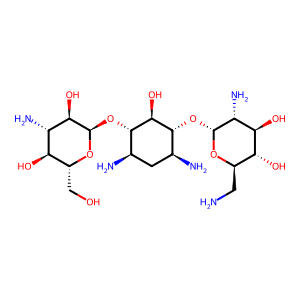

In [14]:
print("Ligand 9CS:")
Draw.MolToImage(Chem.MolFromSmiles(ligand_smiles))

**Note:** Since NeuralPLexer seems to fail to genrate conformers for some SMILE inputs, we will use an SDF moldecule file with all cooradinates are set to zero as ligand input.

In [15]:
path_input_ligand = DATA / complex_pdb / "ligand_zero_coordinates.sdf"

### Run trajectory
As a first example of using NeuralPLexer, we will employ the single trajectory task and predict a conformation of the protein (wihtout the ligand). Using this, we can see, how NeuralPLexer stepwise predictes the protein-ligand complex conformation. Thus, we will first run NeuralPLexer and secondly generate a movie from the resulting frames to showcase the diffusion process. 

**Note:** Due to a potential bug (see TODO), NeuralPLexer does not allow us to input a protein sequence for the single trajectory tasks. Thus, we use a PDB file of the protein as input, where all coordinates are set to zero ([data/6np5/protein_zero_coordinates.pdb](data/6np5/protein_zero_coordinates.pdb)).

In [16]:
input_protein = DATA / complex_pdb / "protein_zero_coordinates.pdb"
out_path_trajectory = DATA / f"results_trajectory_{complex_pdb}"

**Note:** The resulting NeuralPLexer conformation is already precalculated, the next cell can also be skipped if - for example - NeuralPLexer is not available on your machine. 

This takes a while (~4-5 minutes).

In [17]:
run_neuralplexer(
    "single_sample_trajectory",
    input_protein,
    str(out_path_trajectory) + "/",
    model,
    ligand=None,
    num_steps=100,
)

Running conda run -n neuralplexer_dev neuralplexer-inference --task single_sample_trajectory --input-receptor /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein_zero_coordinates.pdb --out-path /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_trajectory_6np5/  --model-checkpoint /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/models/complex_structure_prediction.ckpt --sampler langevin_simulated_annealing --n-samples 1 --chunk-size 1 --num-steps 100 


Successfully 


To show the steps of the conformation prediction process, we load the conformations as a trajcetory the mdtraj package and visualize them interactivly using NGLView.

In [55]:
traj = mdtraj.load(out_path_trajectory / "_prot.pdb")
view = nv.show_mdtraj(traj)
view

NGLWidget(max_frame=100)

When running the movie, we can see, that the protein is moving rapidly in the beginning but seem to convergate to one conformation in the end. However, we see that even in the end, the chain seems to be discontinous, and might not represent a true conformation.

In [56]:
_ = view.render_image(trim=True, factor=2)

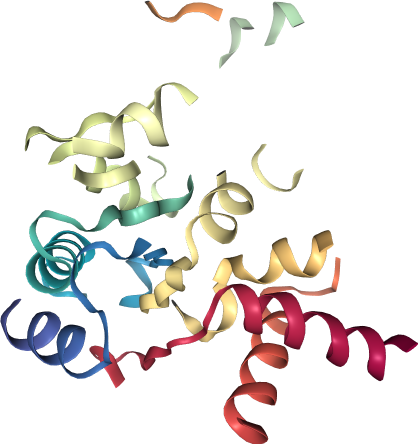

In [57]:
view._display_image()

Let's see how NeuralPLexer performs when predicting the whole protein-ligand complex conformation.

### Complex Prediction
In this section, we will use NeuralPLexer to predict to whole protein ligand stucture of the TODO protein with ligand TODO. To assess the resulting structure, we will compare the result with the cocrystallized structure (PDB code: 6np5) using a Ramachandran plot, as well as, a visual inspection of the structures. 

We first run NeuralPLexer using the batched_structure_sampling task.

In [22]:
# define output path
out_path_complex_prediction = DATA / f"results_flexible_receptor_{complex_pdb}"

**Note:** The resulting NeuralPLexer conformation is already precalculated, the next cell can also be skipped if - for example - NeuralPLexer is not available on your machine. 

In [23]:
run_neuralplexer(
    "batched_structure_sampling",
    protein_sequence,
    out_path_complex_prediction,
    model,
    path_input_ligand,
)

Running conda run -n neuralplexer_dev neuralplexer-inference --task batched_structure_sampling --input-receptor TPWSKSELVRQLRDLGVRSGDMVMPHVSLRAVGPLADGPQTLVDALIEAVGPTGNILAFVSWRDSPYEQTLGHDAPPAAIAQSWPAFDPDHAPAYPGFGAINEFIRTYPGCRRSAHPDASMAAIGPDAAWLVAPHEMGAAYGPRSPIARFLAHAGKILSIGAGPDAVTALHYAEAVARIEGKRRVTYSMPLLREGKRVWVTTSDWDSNGILDEYAAPDGPDAVERIARDYLARTRVAQGPVGGAQSRLIDAADIVSFGIEWLEARHAA --out-path /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_flexible_receptor_6np5  --model-checkpoint /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/models/complex_structure_prediction.ckpt --sampler langevin_simulated_annealing --n-samples 1 --chunk-size 1 --num-steps 100 --input-ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand_zero_coordinates.sdf 
Successfully 


In [24]:
with open(out_path_complex_prediction / "prot_all.pdb") as f:
    view = nv.show_file(f, ext="pdb")
with open(out_path_complex_prediction / "lig_all.sdf") as f:
    view.add_component(f, ext="sdf")
view

NGLWidget()

In [30]:
_ = view.render_image(trim=True, factor=2)

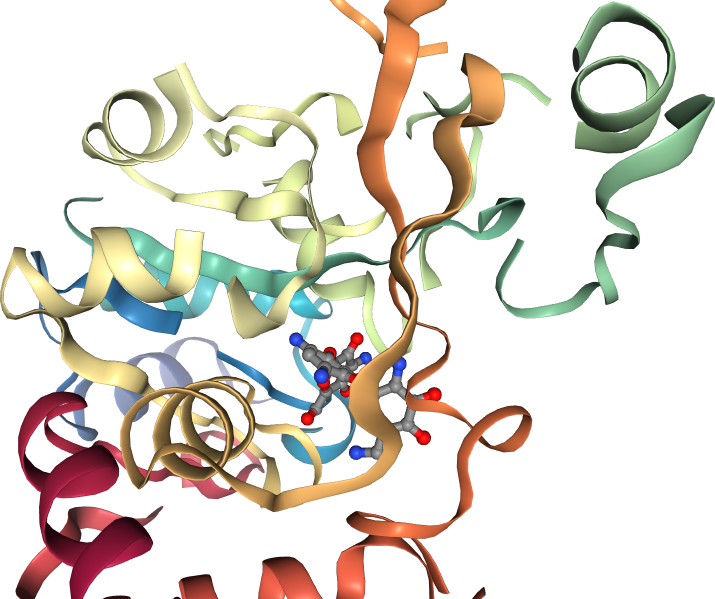

In [31]:
view._display_image()

Here, we see the predicted complex conformation. The ligand seems to be interacting with the protein, and there seems to be no clashes. However, when inspecting the protein conformation, we again observe that the chain is discontinous in some areas.

#### Ramachandran Plot
To assess the secondary structure of the predicted protein conformation, we use a Ramachandran plot. This plot represents the distribution of the two dihedral angles, $\phi$ and $\psi$, of the protein's backbone. This distribution can be then used to assess wether the protein conformation adaopts common secondary structure, such as $\alpha$-helix, or $\beta$-sheet, , and whether the angles are physiochemically allowed.

To calculate the dihedral angles and plot them, we use the MDAnalysis package and MathPlotLib. To this end, we first load the protein conformation as an MDAnalysis Universe, and calculate the dihedral angles using the Ramachandran class. As a reference, we “allowed region” and the “marginally allowed” regions in blue to the plot.

In [33]:
# load protein
u = mda.Universe(DATA / f"results_flexible_receptor_{complex_pdb}" / "prot_all.pdb")

# calculate dihedral angles
R = Ramachandran(u).run()

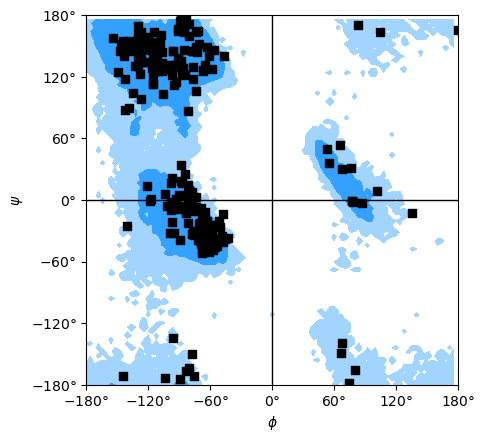

In [34]:
# plot the angles
fig, ax = plt.subplots(figsize=plt.figaspect(1))
R.plot(ax=ax, color="k", marker="s", ref=True)

plt.show()

If we know look at the resulting plot, we see that most residue conformations are within the “marginally allowed” regions, suggesting that their conformations are physiochemically feasible. Further, we notice that there is a high density at the area at the top right corner ($\alpha$-helix), and in the center on the right ($\beta$-sheet). 

#### Visual Inspection
To compare the original protein-ligand structure with the predicted one, we need to superimpose the two complex conformations first.

In [35]:
path_protein = DATA / complex_pdb / "protein.pdb"

In [36]:
def superimpose(ref_structure, predicted_structure):
    """
    Superimposes a predicted structure to a refernce structure,
    assuming the sequence of both proteins are equal and returns the minimized the RMSD.

    Parameters
    ----------
    ref_structure : Bio.PDB.Structure
        Reference protein structure
    predicted_structure : Bio.PDB.Structure
        Predicted protein structure

    Returns
    -------
    float
        The RMSD value between the reference and predicted structures after alignment.
    """

    # code adapted from https://warwick.ac.uk/fac/sci/moac/people/students/peter_cock/python/protein_superposition/

    ref_atoms = []
    alt_atoms = []
    for ref_chain, alt_chain in zip(ref_structure, predicted_structure):
        for ref_res, alt_res in zip(ref_chain, alt_chain):
            ref_atoms.append(ref_res["CA"])
            alt_atoms.append(alt_res["CA"])

    super_imposer = Bio.PDB.Superimposer()
    super_imposer.set_atoms(ref_atoms, alt_atoms)

    super_imposer.apply(predicted_structure.get_atoms())

    return super_imposer.rms

In [37]:
ref_structure = Bio.PDB.PDBParser(QUIET=True).get_structure(complex_pdb, path_protein)[
    0
]
predicted_structure = Bio.PDB.PDBParser(QUIET=True).get_structure(
    complex_pdb + "_neuralplexer", out_path_complex_prediction / "prot_all.pdb"
)[0]

rmsd = superimpose(ref_structure, predicted_structure)

print(f"RMSD after superimposition: {rmsd:.3}")

RMSD after superimposition: 3.28


In [38]:
view = nv.show_biopython(ref_structure, default_representation=False)
view[0].add_cartoon(color="green")

view.add_component(nv.BiopythonStructure(predicted_structure))
view[1].clear_representations()
view[1].add_cartoon()

view

NGLWidget()

In [39]:
_ = view.render_image(trim=True, factor=2)

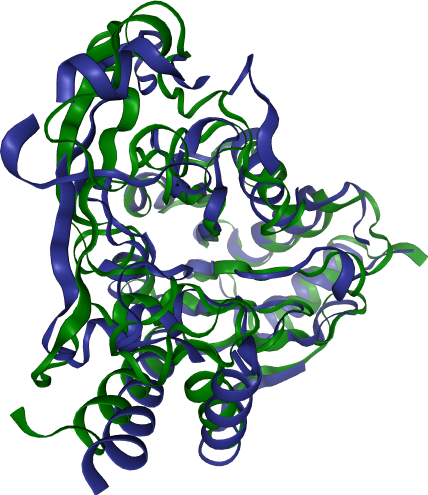

In [40]:
view._display_image()

After aligning (superimposing) the predicted structure to the cocrystallized conformation, we see that both conformation show similar or overlapping regions and seem to fit most secondary motifs rather well, but there are several regions, where both structure derivate by some magnitude. 

### Docking comparision
Within this section, we will compare NeuralPLexer with convential docking. We will use the docking tool AutoDock (TODO cite), that performs rigid-body-flexible-ligand docking. To make a *fair* comparision, we will (1) run templated NeuralPLexer task that will use a given protein strcuture - here the structure of the input sequence - as template. (2) we will run docking on that structure, and (3) calculcate the RMSD between the respective resulting ligand conformation with the cocrystallized one (`6np5`).

#### Templated NeuralPLexer
We first run NeuralPLexer using the protein structure as template to generate the ligand pose for a rigid protein (similar to docking).

In [41]:
# define output path and path to template protein
out_path_docking = DATA / f"results_rigid_receptor_{complex_pdb}"
path_ligand_original = DATA / complex_pdb / "ligand.sdf"

To successfully run docking, we calculate a 3D-conformation of the ligand using RDKit. This we will than use as input for both, the docking and the NeuralPLexer. 

In [42]:
m = next(Chem.SDMolSupplier(path_input_ligand, removeHs=False))
AllChem.EmbedMolecule(m)
AllChem.MMFFOptimizeMolecule(m)

# write ligand
path_input_ligand_3d = DATA / complex_pdb / "ligand_3d.sdf"

with Chem.SDWriter(path_input_ligand_3d) as w:
    w.write(m)

**Note:** The resulting NeuralPLexer conformation is already precalculated, the next cell can also be skipped if - for example - NeuralPLexer is not available on your machine. 

This takes a while (~4-5 minutes).

In [43]:
run_neuralplexer(
    "batched_structure_sampling",
    path_protein,
    out_path_docking,
    model,
    ligand=path_input_ligand_3d,
    template=path_protein,
)

Running conda run -n neuralplexer_dev neuralplexer-inference --task batched_structure_sampling --input-receptor /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein.pdb --out-path /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_rigid_receptor_6np5  --model-checkpoint /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/models/complex_structure_prediction.ckpt --sampler langevin_simulated_annealing --n-samples 1 --chunk-size 1 --num-steps 100 --input-ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand_3d.sdf --use-template --input-template /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein.pdb 
Successfully 


#### Docking with Autodock
For the docking benchmark we employ the AutoDock (TODO cite) docking engine, which was already introduced in the Talktorial T015 (TODO link). To pass the binding pocket to Smina, we use the original ligand from which Smina derives a bounding box. **Note**, that the functionality for this is taken from Talktorial T015 (TODO link).

In [44]:
run_shell_command(
    f"""smina --ligand {path_input_ligand_3d}\
                    --receptor {path_protein}\
                    --out {out_path_docking / "docking_poses.sdf"}\
                    --autobox_ligand {path_ligand_original}\
                    --num_modes 1 \
                    --exhaustiveness 8\
                    --seed 42""",
    print_success=False,
)

Running smina --ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand_3d.sdf                    --receptor /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/protein.pdb                    --out /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/results_rigid_receptor_6np5/docking_poses.sdf                    --autobox_ligand /home/katharina/CADDSeminar_2024/Topic2a_NeuralPlexer/data/6np5/ligand.sdf                    --num_modes 1                     --exhaustiveness 8                    --seed 42
   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Wei

##### Visualizing NeuralPLexer and docking results 
Let's first visually compare the NeuralPLexer and docking results with the original ligand conformation.

In [49]:
def show_multiple_ligands(protein_path, ligand_paths, ligand_names=None, colors=None):
    """
    Visualize a protein with multiple ligands in NGLView.

    Parameters
    ----------
    protein_path : str
        File path to the protein structure (PDB)
    ligand_paths : list(str)
        List of file paths to the ligand structures in SDF format
    ligand_names : list of str, optional
        List of names for the ligands for legend
    colors : list of str, optional
        List of colors to assign to each ligand.

    Returns
    -------
    nv.NGLWidget
        NGLView widget displaying the protein with the specified ligands
    """
    with open(protein_path) as f:
        view = nv.show_file(f, ext="pdb")
    for i, lig_path in enumerate(ligand_paths):
        with open(lig_path) as f:
            view.add_component(f, ext="sdf")
    view.center(component=1)

    if colors:
        print(f"Color scheme:")
        for i in range(1, len(ligand_paths)):
            color = colors[i - 1]
            print(f"{color}\t-\t{ligand_names[i]}")
            view[i + 1].clear_representations()
            view.add_representation("licorice", component=i + 1, color=color)

    view.center(component=1)
    return view

In [50]:
view = show_multiple_ligands(
    path_protein,
    [
        path_ligand_original,
        out_path_docking / "docking_poses.sdf",
        out_path_docking / "lig_all.sdf",
    ],
    ["cocrystallized", "docking", "NeuralPLexer"],
    ["blue", "purple"],
)
view

Color scheme:
blue	-	docking
purple	-	NeuralPLexer


NGLWidget()

In [51]:
_ = view.render_image(trim=True, factor=2)

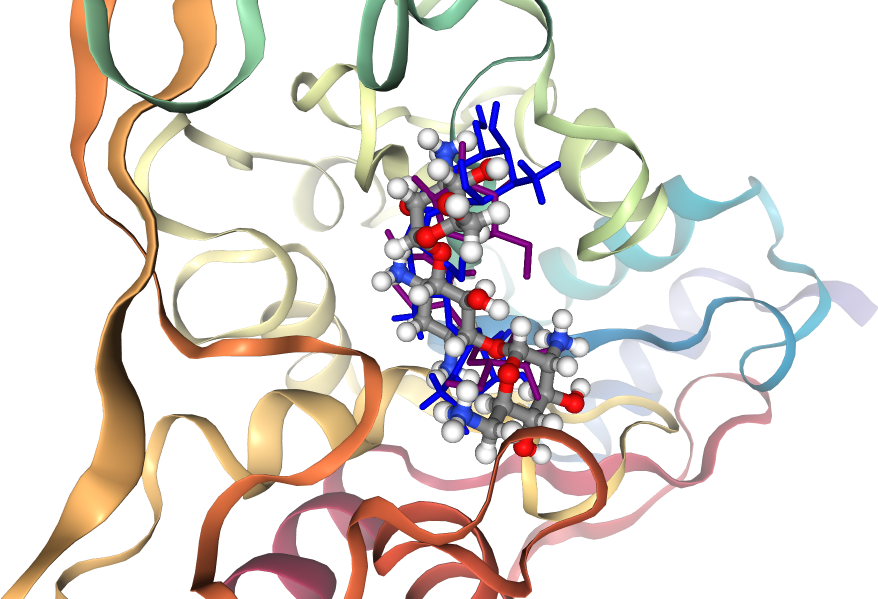

In [52]:
view._display_image()

Comparing the docking (blue) and NeuralPLexer (purple) conformation with the cocrystallized conformation, we observe that the NeuralPLexer solution seems to have a similar conformation while docking soltuion derivate a bit. 

##### Calculating the RMSD
To determine, how much the docking and respecticly NeuralPLexer ligand conformation derivade from the corcrystallized ligand, we calculate the RMSD between the respective conformations. 

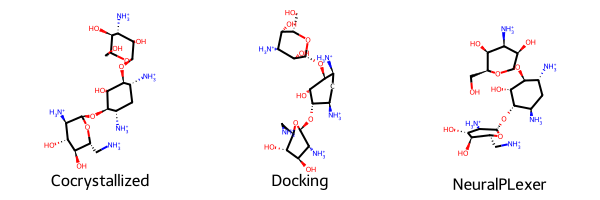

In [58]:
# load ligand conformations
ligand_original = next(Chem.SDMolSupplier(path_ligand_original))
ligand_docking = next(Chem.SDMolSupplier(out_path_docking / "docking_poses.sdf"))
ligand_np = next(Chem.SDMolSupplier(out_path_docking / "lig_all.sdf"))
MolsToGridImage(
    mols=[ligand_original, ligand_docking, ligand_np],
    legends=["Cocrystallized", "Docking", "NeuralPLexer"],
    molsPerRow=3,
)

In [54]:
print(
    f"RMSD between NP ligand pose and cocrystallized pose:\t{rdMolAlign.CalcRMS(ligand_np, ligand_original)}"
)
print(
    f"RMSD between docking pose and cocrystallized pose:\t{rdMolAlign.CalcRMS(ligand_docking, ligand_original)}"
)

RMSD between NP ligand pose and cocrystallized pose:	2.4472793345288815
RMSD between docking pose and cocrystallized pose:	4.191233990705899


Approaching the RMSD, we also see that the NeuralPLexer solution seems to be closer to the cocrystallized ligand than the docking solution. However, note that this ligand was obtained in PDBBind and thus this comparision **cannot** be used to draw any conlcusions on general performance.

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># TODO: CI</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>